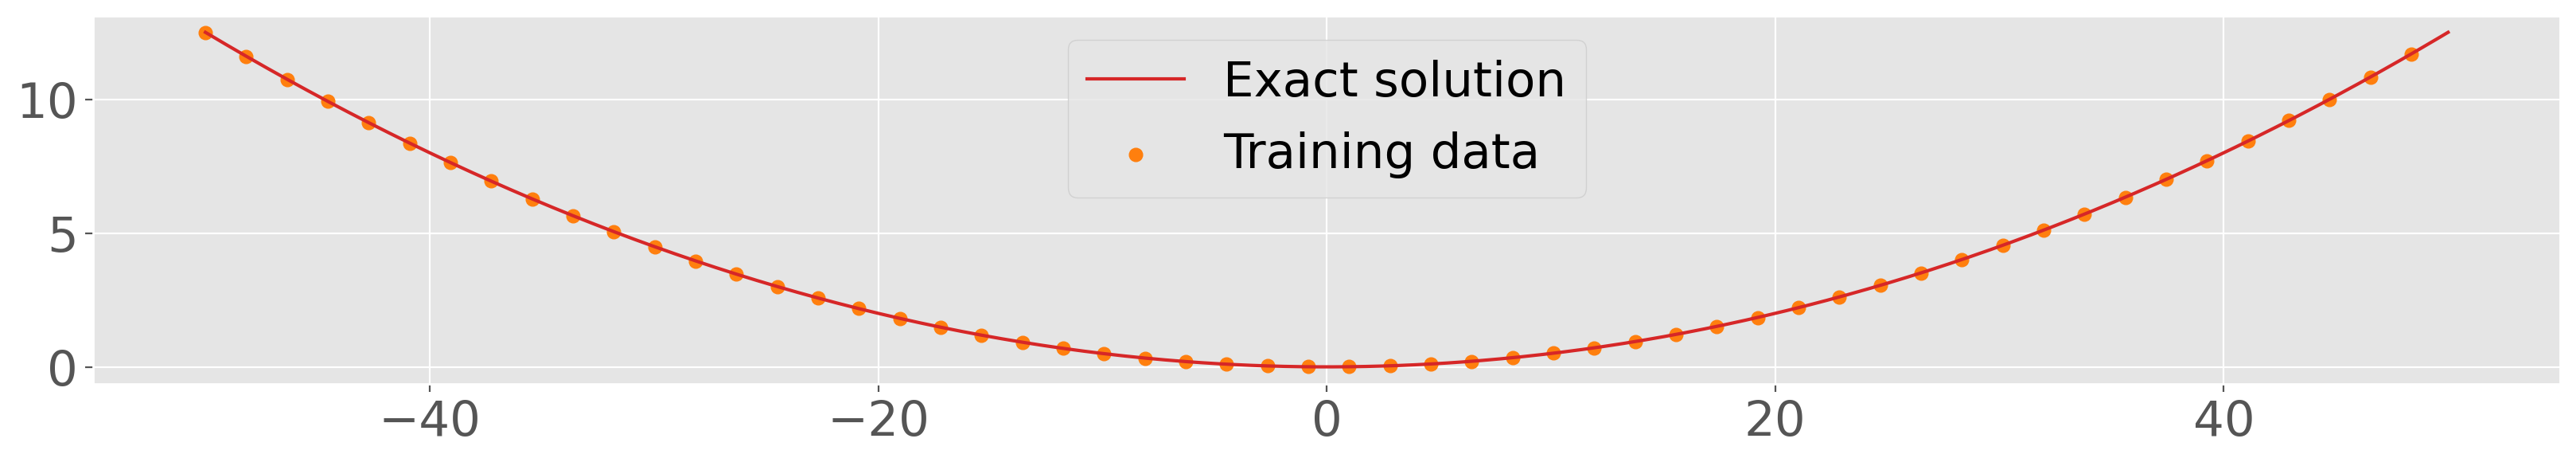

Epoch 1/600
1/1 [==============================] - 2s 2s/step - loss: 3.3338 - lr: 0.0100
Epoch 2/600
1/1 [==============================] - 0s 15ms/step - loss: 1528.8538 - lr: 0.0100
Epoch 3/600
1/1 [==============================] - 0s 16ms/step - loss: 52.4147 - lr: 0.0100
Epoch 4/600
1/1 [==============================] - 0s 23ms/step - loss: 41.6578 - lr: 0.0100
Epoch 5/600
1/1 [==============================] - 0s 16ms/step - loss: 66.8270 - lr: 0.0100
Epoch 6/600
1/1 [==============================] - 0s 17ms/step - loss: 57.4616 - lr: 0.0100
Epoch 7/600
1/1 [==============================] - 0s 17ms/step - loss: 29.2871 - lr: 0.0100
Epoch 8/600
1/1 [==============================] - 0s 16ms/step - loss: 8.7039 - lr: 0.0100
Epoch 9/600
1/1 [==============================] - 0s 16ms/step - loss: 1.8975 - lr: 0.0100
Epoch 10/600
1/1 [==============================] - 0s 19ms/step - loss: 6.2466 - lr: 0.0100
Epoch 11/600
1/1 [==============================] - 0s 274ms/step - loss:

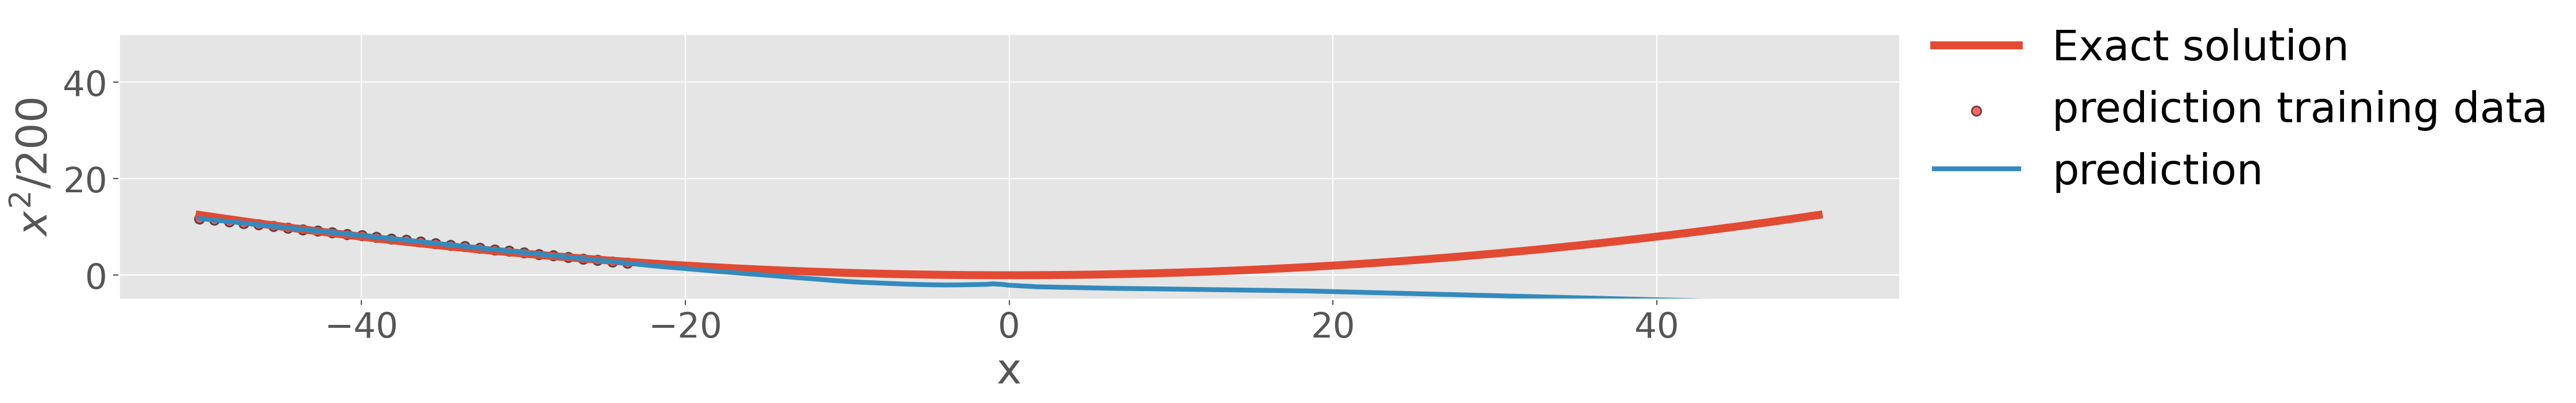

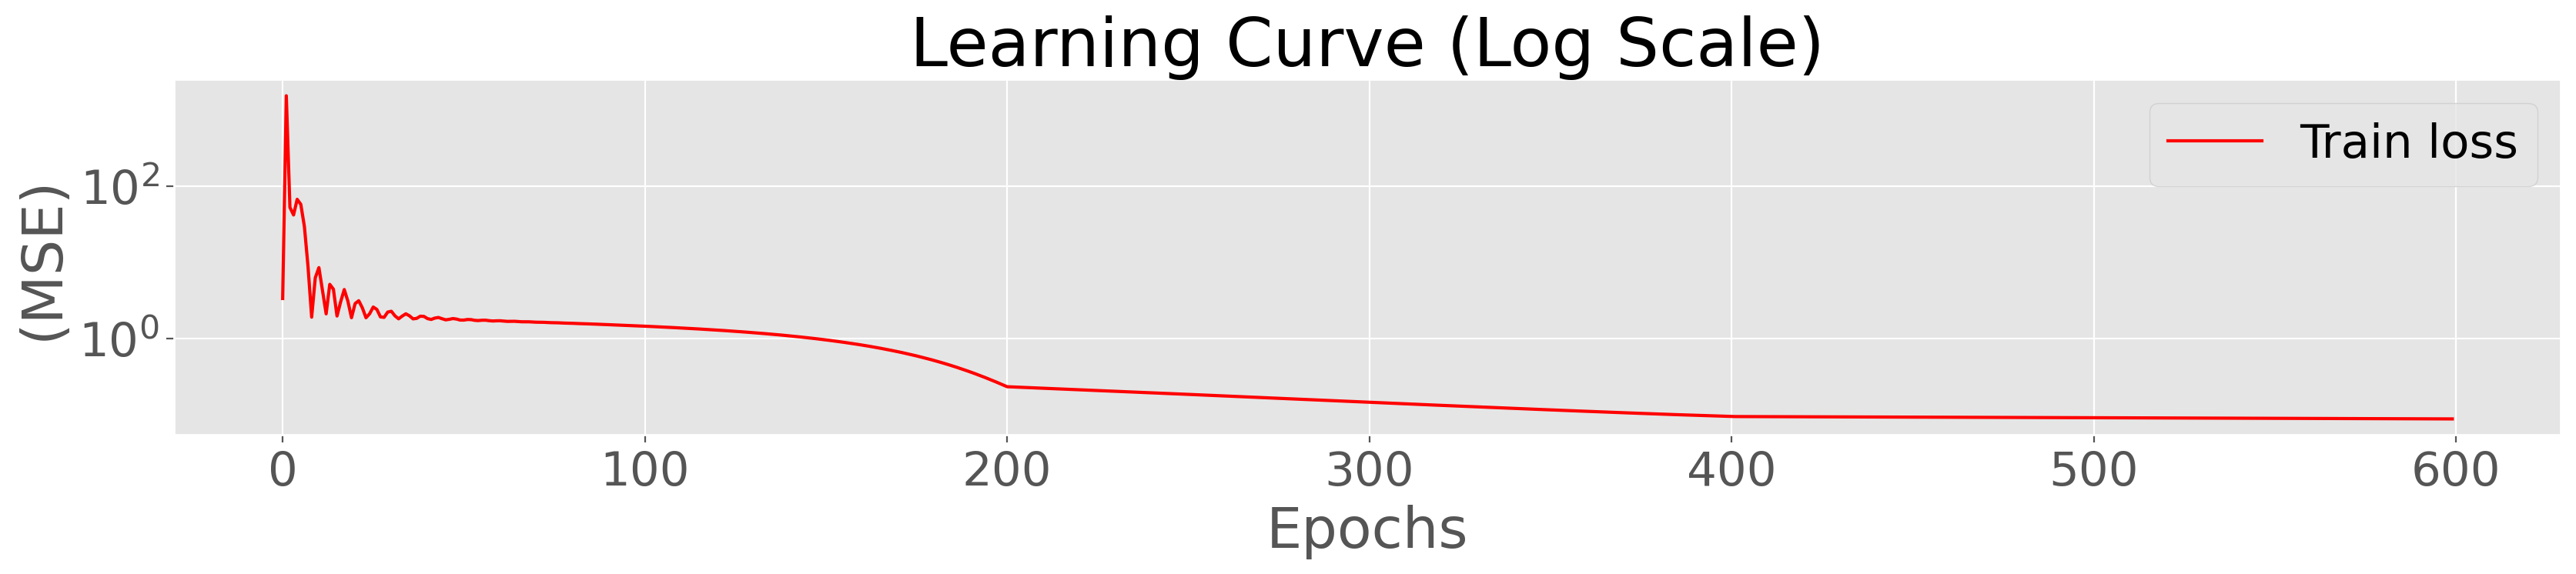

In [1]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio

plt.style.use('ggplot')

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200  # high-res display
plt.rcParams["figure.figsize"] = (20, 3)
plt.rcParams.update({'font.size': 22})

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data Generation
ndata = 550
x = np.linspace(-50, 50, ndata)
y = x**2/200
n = len(x)  # Number of data points

# Slice out a small number of points from the LHS of the domain
x_data = x[0:550:10]
y_data = y[0:550:10]

# To visualize before passing through the model
plt.figure()
plt.plot(x, x**2/200, color="tab:red", label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

# Visualize model performance on the whole x data
class PerformancePlotCallbackn(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test, x, count, model_name):
        self.x_test = x_test
        self.y_test = y_test
        self.count = count
        self.model_name = model_name
        self.x = x

    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.count = self.count + 1
            y_pred = self.model.predict(self.x)

            fig, ax = plt.subplots(figsize=(8, 4))
            plt.scatter(self.x, y_pred, alpha=0.6,
                        color='#FF0000', lw=1, ec='black')

            plt.scatter(self.x_test, self.y_test, alpha=0.1,
                        color='blue', lw=1, ec='black')

            lims = [-50, 50]

            plt.plot(self.x, self.x**2/200, lw=1, color='#0000FF')
            plt.ticklabel_format(useOffset=False, style='plain')
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.xlim(lims)
            plt.ylim([-5, 20])

            plt.xlabel('x')
            plt.ylabel('$x^2/200$')

            plt.tight_layout()
            plt.title(f'Prediction Visualization  - Epoch: {epoch}', fontsize=18)

            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            my_images.append(image)
            plt.close()


# Building up model 2d
my_images = []
x_data = x[0:150:5]
y_data = y[0:150:5]
model2d = tf.keras.Sequential()
model2d.add(tf.keras.layers.Dense(132, input_shape=[1]))
model2d.add(tf.keras.layers.Dense(132, activation='relu'))
model2d.add(tf.keras.layers.Dense(132, activation='relu'))
model2d.add(tf.keras.layers.Dense(1))

# Compilation of Model 2D
def lr_schedule(epoch):
    if epoch < 200:
        return 1e-2
    elif epoch < 400:
        return 1e-3
    else:
        return 1e-4

# Create a LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile your model with an initial learning rate
initial_learning_rate = 1e-2
model2d.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate))

# callback
performance = PerformancePlotCallbackn(x_data, y_data, x, 0, "RegressionQ")
history = model2d.fit(x_data, y_data, epochs=600, batch_size=32, callbacks=[performance, lr_scheduler])

# Save images as a gif
imageio.mimsave('./para2.gif', my_images, fps=10)

# Passing data through MODEL 2D
plt.figure()
x_data = x[0:150:5]
y_data = y[0:150:5]
plt.plot(x, x**2/200, lw=5, label="Exact solution")
plt.scatter(x_data, model2d.predict(x_data), alpha=0.6,
            color='#FF0000', lw=1, ec='black', label="prediction training data")

plt.plot(x, model2d.predict(x), lw=3, label="prediction")
plt.ylim([-5, 50])
plt.xlabel('x')
plt.ylabel('$x^2/200$')

l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")

# Plot the learning curve (MSE vs. Epochs) in log scale
plt.figure()
plt.semilogy(np.arange(len(history.history['loss'])), history.history['loss'], color='r', label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('(MSE)')
plt.title('Learning Curve (Log Scale)')
plt.legend()
plt.show()
